In [1]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, concatenate, add
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop
from keras.utils.data_utils import get_file
import random
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import VGG16, ResNet50, VGG16
import os
import itertools
import cv2
from sklearn.metrics import log_loss, confusion_matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 150
image_height = 150

img_rows =  224
img_cols =  224
image_size = (image_width, image_height)

data_datagen = ImageDataGenerator(rescale=1.0/255,  validation_split=0.20, featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True,  
        vertical_flip=False)

train_generator = data_datagen.flow_from_directory(
        '../input/simpsons-dataset/simpsons_dataset/simpsons_dataset/',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',
         subset='training')

validation_generator = data_datagen.flow_from_directory(
        '../input/simpsons-dataset/simpsons_dataset/simpsons_dataset/',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',
         subset='validation', shuffle = False)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
       '../input/dataset-simpsons-test/kaggle_simpson_testset/',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',shuffle = False)

Found 11054 images belonging to 10 classes.
Found 2757 images belonging to 10 classes.
Found 456 images belonging to 10 classes.


In [5]:
def create_model():
    resnet50 = ResNet50(include_top=False, input_shape=(150, 150, 3))
    
    model = Sequential()
    model.add(resnet50)
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation = "relu"))
    model.add(Dense(10, activation='softmax'))   
    model.summary()
    #sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    rmsprop = RMSprop(lr=1e-3, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc'])
    return model

In [6]:
model = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 2048)        8192      
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 36,705,930
Trainable params: 36,648,714
Non-trainable params: 57,216
___________________________________________________________

In [7]:
n_train = 11054
batch_size = 32
n_valid = 2757
history = model.fit_generator(
       train_generator,
       steps_per_epoch=n_train//batch_size,
       epochs=10,
       validation_data=validation_generator,
       validation_steps=n_valid//batch_size)

Epoch 1/10
345/345 [==============================] - 166s 480ms/step - loss: 5.1358 - acc: 0.1261 - val_loss: 2.5161 - val_acc: 0.3227
Epoch 2/10
345/345 [==============================] - 147s 425ms/step - loss: 3.2031 - acc: 0.1582 - val_loss: 11.4514 - val_acc: 0.0603
Epoch 3/10
345/345 [==============================] - 147s 426ms/step - loss: 3.3234 - acc: 0.1536 - val_loss: 2.5034 - val_acc: 0.3231
Epoch 4/10
345/345 [==============================] - 146s 423ms/step - loss: 3.3941 - acc: 0.1636 - val_loss: 5.9407 - val_acc: 0.0560
Epoch 5/10
345/345 [==============================] - 146s 424ms/step - loss: 3.2599 - acc: 0.1497 - val_loss: 2.7160 - val_acc: 0.3282
Epoch 6/10
345/345 [==============================] - 146s 423ms/step - loss: 3.1673 - acc: 0.1612 - val_loss: 3.5955 - val_acc: 0.0218
Epoch 7/10
345/345 [==============================] - 146s 424ms/step - loss: 3.1763 - acc: 0.1536 - val_loss: 9.6007 - val_acc: 0.1414
Epoch 8/10
345/345 [===========================

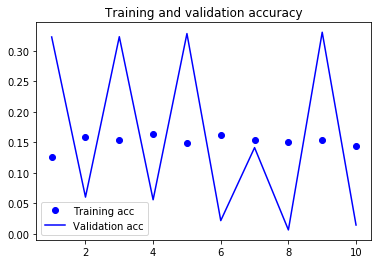

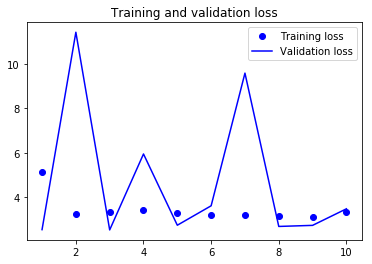

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best');

In [9]:
n_test = 456
Y_pred = model.predict_generator(test_generator, n_test//16+1)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)

In [10]:

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)

Confusion Matrix


In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 0  0 49  0  0  0  1  0  0  0]
 [ 0  0 35  0  0  0  1  0  0  0]
 [ 0  0 46  0  0  0  4  0  0  0]
 [ 0  0 39  0  0  0  3  0  0  0]
 [ 0  0 43  0  0  0  2  0  0  0]
 [ 0  0 49  0  0  0  1  0  0  0]
 [ 0  0 45  0  0  0  4  0  0  0]
 [ 0  0 44  0  0  0  0  0  0  0]
 [ 0  0 46  0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  1  0  0  0]]


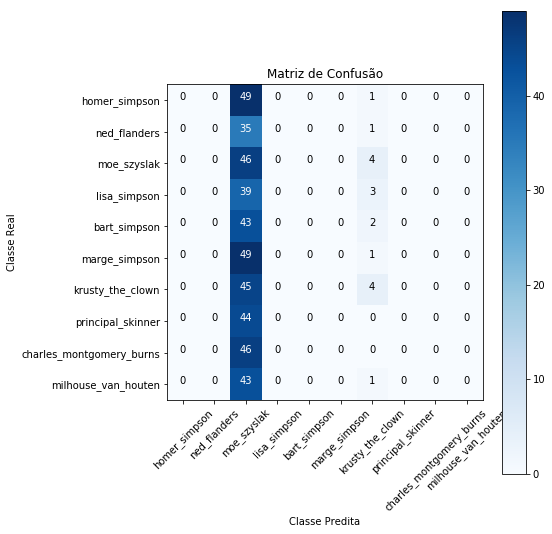

In [12]:
nomes_classes=['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson','bart_simpson',
         'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']
plot_confusion_matrix(cm, classes=nomes_classes,
                      title='Matriz de Confusão')

In [13]:
target_names=['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 
                 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 
                 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']
print (classification_report (test_generator.classes, y_pred, target_names = target_names))

                          precision    recall  f1-score   support

           homer_simpson       0.00      0.00      0.00        50
            ned_flanders       0.00      0.00      0.00        36
             moe_szyslak       0.10      0.92      0.19        50
            lisa_simpson       0.00      0.00      0.00        42
            bart_simpson       0.00      0.00      0.00        45
           marge_simpson       0.00      0.00      0.00        50
        krusty_the_clown       0.24      0.08      0.12        49
       principal_skinner       0.00      0.00      0.00        44
charles_montgomery_burns       0.00      0.00      0.00        46
     milhouse_van_houten       0.00      0.00      0.00        44

             avg / total       0.04      0.11      0.03       456

